### Make necessary imports

In [1]:
import sys
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

sys.path.append('../batchflow')

from batchflow import Config, Pipeline, B, V
from batchflow.opensets import MNIST
from batchflow.models.torch import TorchModel
from batchflow.models.metrics import ClassificationMetrics

### Load dataset

In [2]:
mnist = MNIST()

### Define model configs

In [3]:
config_0 = {
    'inputs': dict(images={'shape': (1, 28, 28),
                           'data_format': 'channels_first'},
                   labels={'classes': 10}),
    'initial_block/inputs': 'images',
    'body/layout': 'f',
    'body/units': 10,
    'output': dict(predicted=['proba', 'labels']),
    'optimizer': 'Adam',
    'loss': 'ce',
}

config_1 = config_0 + Config({'body/layout' : 'fa f'})

configs = [config_0, config_1]

### Define train pipelines

In [4]:
def make_train_template(config):
    train_template = (Pipeline()
        .init_variable('loss', default=[])
        .to_array('float32', 'channels_first')
        .init_model('dynamic', TorchModel, 'model', config)
        .train_model('model', B.images, B.labels, fetches='loss', save_to=V('loss', mode='a'))
    )
    return train_template

In [5]:
BATCH_SIZE = 64
N_ITERS = 1000

train_pipelines = []
for config in configs:
    train_template = make_train_template(config)
    train_pipeline = mnist.train >> train_template
    train_pipeline.run(batch_size=BATCH_SIZE, n_iters=N_ITERS, bar='n', shuffle=True, drop_last=True)
    train_pipelines.append(train_pipeline)

### Plot models loss

In [ ]:
AVER = 10000

colors = ['olivedrab', 'darkmagenta']
plt.figure(figsize=(20,8))
plt.legend(['f', 'ff'])

for i, train_pipeline in enumerate(train_pipelines):
    loss = train_pipeline.v('loss')
    aver = np.array([np.mean(l) for l in np.array_split(loss, AVER)])[:100]
    plt.plot(aver, colors[i])

### Define test pipelines

In [7]:
def make_test_template(train_pipeline):
    test_template = (Pipeline()
        .init_variable('predictions')
        .init_variable('metrics', default=[])
        .import_model('model', train_pipeline)
        .to_array('float32', 'channels_first')
        .predict_model('model', B.images, fetches='predicted_proba', save_to=V.predictions)
        .gather_metrics(ClassificationMetrics, targets=B.labels, predictions=V.predictions, fmt='logits', axis=1, save_to=V('metrics', mode='a'))
    )
    return test_template

### Run test pipelines

In [8]:
test_pipelines = []
for train_pipeline in train_pipelines:
    test_template = make_test_template(train_pipeline)
    test_pipeline = mnist.test >> test_template
    _ = test_pipeline.run(batch_size=1, n_epochs=1, bar='n')
    test_pipelines.append(test_pipeline)

### Plot confusion matrices for our predictions

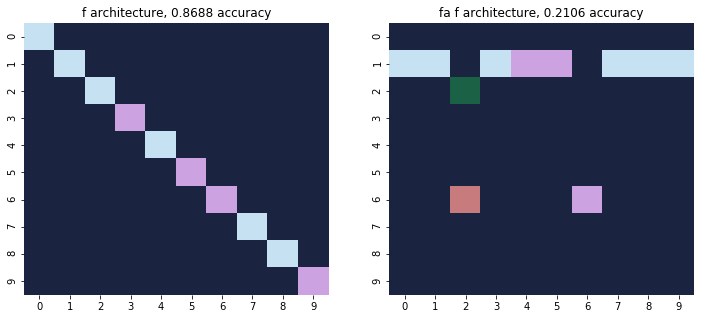

In [9]:
fig, axes = plt.subplots(1, 2, figsize=(12,5))

for ax, test_pipeline in zip(axes, test_pipelines):
    title = test_pipeline.m('model').config['body/layout']
    metrics = test_pipeline.get_variable('metrics')
    accuracy = np.mean([m.evaluate('acc') for m in metrics])
    confusion_matrix = np.sum([m._confusion_matrix for m in metrics], axis=0).squeeze()
    heatmap = sns.heatmap(confusion_matrix, ax=ax, cmap=sns.color_palette('cubehelix'), cbar=False).set_title('{} architecture, {} accuracy'.format(title, accuracy))

### Reset pipelines and run them again, checking accuracy on test each `N_REPS` iterations

In [13]:
N_REPS = 10
N_ITERS = 100

_ = [train_pipeline.reset(['iter', 'vars', 'models']) for train_pipeline in train_pipelines]
_ = [test_pipeline.reset(['iter', 'vars', 'models']) for test_pipeline in test_pipelines]

for train_pipeline, test_pipeline in zip(train_pipelines, test_pipelines):
    print('Run {} model'.format(test_pipeline.m('model').config['body/layout']))
    for rep in range(N_REPS):
        train_pipeline.run(batch_size=BATCH_SIZE, n_iters=N_ITERS, bar='n', shuffle=True, drop_last=True, bar_desc='Train №{}'.format(rep))
        test_pipeline.run(batch_size=1, n_epochs=1, bar='n', bar_desc='Test №{}'.format(rep))

Run f model



Run fa f model


### Plot accuracy change on test subset for both our models

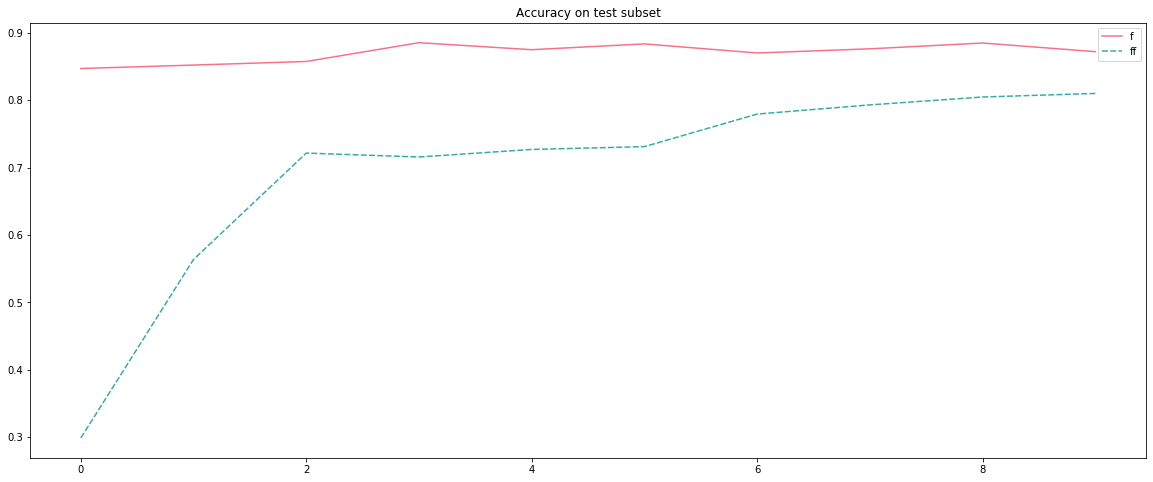

In [14]:
accuracies = [np.mean(np.array_split([m.evaluate('acc') for m in test_pipeline.v('metrics')], N_REPS), axis=1) for test_pipeline in test_pipelines]
plt.figure(figsize=(20, 8))
sns.lineplot(data=accuracies, palette='husl').set_title('Accuracy on test subset')
plt.legend(['f', 'ff']);

In [ ]:
train_pipelines[1].m('model').model._modules['body']._modules['group_modules']._modules['0']._modules['0']._modules['block_modules']._modules['0']

In [ ]:
tmp = make_test_template(train_pipelines[1])
ppl = mnist.train >> tmp
ppl.run(batch_size=1, n_epochs=1, bar='n')

In [ ]:
np.mean([m.evaluate('acc') for m in ppl.v('metrics')])

In [ ]:
np.sum([m._confusion_matrix for m in ppl.v('metrics')], axis=0).squeeze()

In [ ]:
np.mean(train_pipelines[1].v('loss')[:100])

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(12,5))

for ax, test_pipeline in zip(axes, test_pipelines):
    title = test_pipeline.m('model').config['body/layout']
    metrics = test_pipeline.get_variable('metrics')[-10000:]
    accuracy = np.mean([m.evaluate('acc') for m in metrics])
    confusion_matrix = np.sum([m._confusion_matrix for m in metrics], axis=0).squeeze()
    heatmap = sns.heatmap(confusion_matrix, ax=ax, cmap=sns.color_palette('cubehelix'), cbar=False).set_title('{} architecture, {} accuracy'.format(title, accuracy))

In [ ]:
w, b = train_pipelines[1].m('model').model._modules['body']._modules['group_modules']._modules['0']._modules['0']._modules['block_modules']._modules['0']._modules['Layer 0, letter "f"; (None, 1, 28, 28) -> (None, 10)']._modules['linear']._parameters.values()

In [ ]:
model_config_ff_more_units = model_config_ff + Config({'body/units' : [100,10]})
model_config_ff_change_activation = model_config_ff + Config({'body/activation' : 'LeakyRelu'})
model_config_ff_add_normalization = model_config_ff + Config({'body/layout' : 'fan f'})
configs += [model_config_ff_more_units, model_config_ff_change_activation, model_config_ff_add_normalization]